In [9]:
!pip install -q hvplot
# Install memory_profiler 
%pip install memory_profiler

# Load memory_profiler extension
%load_ext memory_profiler

Note: you may need to restart the kernel to use updated packages.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import hvplot.pandas
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier



import time

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


### Introduction
- LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.
- What we are trying to do is to predict the loan approval of a person based on the data we have been given
- Lets now **load** the data and **describe** it.

In [11]:
data = pd.read_csv("train_lending_club.csv")
print("Data imported successfully")
test_data = pd.read_csv("test_lending_club.csv")
print(data.head())
print("Test data imported successfully")
print(test_data.head())


Data imported successfully
      issue_d sub_grade        term home_ownership  fico_range_low  total_acc  \
0  2014-01-01        D1   60 months       MORTGAGE          660.00      18.00   
1  2014-01-01        C4   60 months       MORTGAGE          740.00      26.00   
2  2014-01-01        A4   36 months           RENT          700.00      47.00   
3  2014-01-01        D1   60 months       MORTGAGE          665.00      26.00   
4  2014-01-01        C3   36 months       MORTGAGE          700.00      15.00   

   pub_rec  revol_util  annual_inc  int_rate   dti             purpose  \
0     0.00       86.80    40440.00     16.99 15.16         credit_card   
1     0.00      103.50    59000.00     15.61 16.74         credit_card   
2     0.00       11.40    40000.00      7.90 20.34  debt_consolidation   
3     0.00       56.20    70000.00     16.99 23.15  debt_consolidation   
4     1.00       67.10   120000.00     14.98 17.88            vacation   

   mort_acc  loan_amnt application_type  

### Description of the data



In [12]:
data.describe()

,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,dti,mort_acc,loan_amnt,installment,pub_rec_bankruptcies,fico_range_high,revol_bal,id,open_acc,emp_length,loan_status,time_to_earliest_cr_line
count,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00
mean,694.35,25.57,0.24,52.85,77379.53,12.60,18.53,1.73,14626.43,441.92,0.14,698.35,16956.26,49269391.36,11.81,5.99,0.83,526420.51
std,30.93,12.20,0.67,24.01,77290.67,4.48,9.21,2.04,8611.59,257.21,0.39,30.93,23829.01,20980382.07,5.59,4.24,0.37,241312.11
min,660.00,2.00,0.00,0.00,0.00,5.32,0.00,0.00,1000.00,14.77,0.00,664.00,0.00,56705.00,0.00,0.00,0.00,97113.60
25%,670.00,17.00,0.00,35.00,46000.00,9.17,12.05,0.00,8000.00,254.07,0.00,674.00,6127.00,33191497.25,8.00,2.00,1.00,360374.40
50%,685.00,24.00,0.00,53.00,65000.00,12.29,17.89,1.00,12450.00,378.20,0.00,689.00,11399.00,52979215.50,11.00,6.00,1.00,478483.20
75%,710.00,32.00,0.00,71.20,92000.00,15.31,24.52,3.00,20000.00,588.37,0.00,714.00,20431.00,66645529.25,15.00,11.00,1.00,647049.60
max,845.00,169.00,86.00,182.80,9573072.00,30.99,999.00,47.00,40000.00,1534.88,9.00,850.00,2560703.00,84363456.00,76.00,11.00,1.00,2240524.80


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236846 entries, 0 to 236845
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   issue_d                   236846 non-null  object 
 1   sub_grade                 236846 non-null  object 
 2   term                      236846 non-null  object 
 3   home_ownership            236846 non-null  object 
 4   fico_range_low            236846 non-null  float64
 5   total_acc                 236846 non-null  float64
 6   pub_rec                   236846 non-null  float64
 7   revol_util                236846 non-null  float64
 8   annual_inc                236846 non-null  float64
 9   int_rate                  236846 non-null  float64
 10  dti                       236846 non-null  float64
 11  purpose                   236846 non-null  object 
 12  mort_acc                  236846 non-null  float64
 13  loan_amnt                 236846 non-null  f

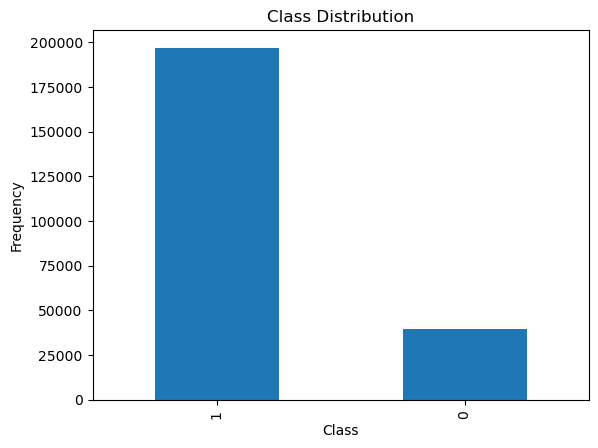

In [14]:
import matplotlib.pyplot as plt
data['loan_status'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


## Data Preprocessing
- Remove or fill any missing data
- scaling
- convert categorical data into numeric 

In [15]:
print(f"The Length of the data: {data.shape}")


The Length of the data: (236846, 27)


In [16]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

# Missing values in test data
for column in test_data.columns:
    if test_data[column].isna().sum() != 0:
        missing = test_data[column].isna().sum()
        portion = (missing / test_data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'home_ownership': number of missing values '826' ==> '0.869%'
'loan_status': number of missing values '1412' ==> '1.486%'


### Label Encoding
- Turning Categorical values into numerical 

In [19]:
# List of categorical columns to convert
categorical_columns = ['sub_grade', 'term', 'home_ownership', 'purpose', 'application_type', 'verification_status', 'initial_list_status']

# One-hot encode these columns
data = pd.get_dummies(data, columns=categorical_columns)

print(f"The Length of the data: {data.shape}")


The Length of the data: (236846, 81)


In [20]:
# remove issue date because before hand we don't know when the loan will be issued
# drop loan_status because it is the target
# drop id,addr_state because it is not useful


# Store 'loan_status' in a separate variable Y
y_train = data['loan_status']

# Now we can safely drop 'issue_d', 'sub_grade', 'loan_status', and 'id' from the dataset
data = data.drop(['issue_d', 'loan_status', 'id', 'addr_state'], axis=1)
X_train = data

# 'X_train' now contains only the features, and 'y_train' is your target variable

X_train.head()
print(f"The Length of the data: {X_train.shape}")



The Length of the data: (236846, 77)


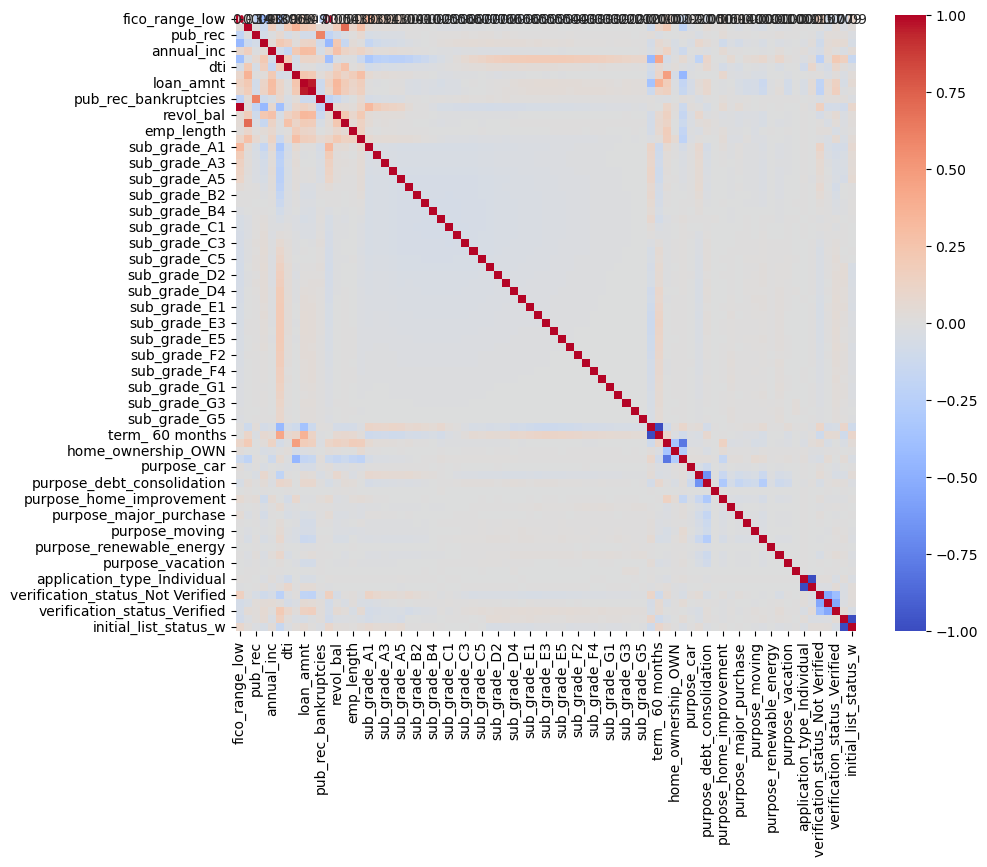

In [21]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

### Logistic Regression


In [22]:
# Scale the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [23]:
logistic_classifier = LogisticRegression(max_iter=1000) # You can adjust regularization parameters if needed
logistic_classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

### KNN CLASSIFIER

In [24]:
# Train KNN Classifier
# in terminal set LOKY_MAX_CPU_COUNT= <number of cores you want to use>

knn_classifier = KNeighborsClassifier(n_neighbors=5) # You can adjust the number of neighbors (k) as needed
knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

### Performance evaluation Milestone 1

In [25]:
# F1 Score for Logistic Regression
logistic_f1_scores = cross_val_score(logistic_classifier, X_train_scaled, y_train, cv=5, scoring='f1')
print("Logistic Regression CV F1 Score:", logistic_f1_scores.mean())

# AUC for Logistic Regression
logistic_auc_scores = cross_val_score(logistic_classifier, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression CV ROC_AUC:", logistic_auc_scores.mean())

# Repeat for KNN
knn_f1_scores = cross_val_score(knn_classifier, X_train_scaled, y_train, cv=5, scoring='f1')
print("KNN CV F1 Score:", knn_f1_scores.mean())

knn_auc_scores = cross_val_score(knn_classifier, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("KNN CV ROC_AUC:", knn_auc_scores.mean())

Logistic Regression CV F1 Score: 0.9033793225069063
Logistic Regression CV AUC: 0.7789966094200176
KNN CV F1 Score: 0.8945972841418024
KNN CV AUC: 0.6943401702263249


In [36]:
def plot_cv_roc_curve(classifier, X, y, cv_splits=5, classifier_name='Classifier'):
    """
    Plots ROC curves for each fold in cross-validation and the mean ROC curve.
    
    Parameters:
    - classifier: The classifier to use.
    - X: Feature set.
    - y: Target variable.
    - cv_splits: Number of cross-validation splits.
    - classifier_name: Name of the classifier (for legend labeling).
    """
    cv = StratifiedKFold(n_splits=cv_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        probas_ = classifier.predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} {classifier_name} (AUC = {roc_auc:.2f})')
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean {classifier_name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f"Receiver Operating Characteristic - {classifier_name}")
    ax.legend(loc="lower right")
    plt.show()


In [28]:
# Measure CPU time for training KNN Classifier
start_time = time.time()
knn_classifier.fit(X_train_scaled, y_train)
end_time = time.time()
print("Time taken for training KNN Classifier:", end_time - start_time, "seconds")

# Measure memory usage for training KNN Classifier
%memit knn_classifier.fit(X_train_scaled, y_train)


# Measure CPU time for training Logistic Regression Classifier
start_time = time.time()
logistic_classifier.fit(X_train_scaled, y_train)
end_time = time.time()
print("Time taken for training Logistic Classifier:", end_time - start_time, "seconds")

# Measure memory usage for training KNN Classifier
%memit logistic_classifier.fit(X_train_scaled, y_train)

Time taken for training KNN Classifier: 0.09354138374328613 seconds
peak memory: 820.09 MiB, increment: 142.79 MiB
Time taken for training Logistic Classifier: 1.0230915546417236 seconds
peak memory: 824.35 MiB, increment: 147.03 MiB


### Linear Discriminant Analysis AND Desicion Trees

In [29]:
# Define the LDA model
lda_model = LinearDiscriminantAnalysis()
# Measure training time for LDA
start_time = time.time()
lda_model.fit(X_train_scaled, y_train)
lda_training_time = time.time() - start_time

print(f"LDA Training Time: {lda_training_time} seconds")

# Define the Decision Tree model
dt_model = DecisionTreeClassifier()

# Measure training time for Decision Trees
start_time = time.time()
dt_model.fit(X_train_scaled, y_train)
dt_training_time = time.time() - start_time

print(f"Decision Tree Training Time: {dt_training_time} seconds")



LDA Training Time: 2.7809574604034424 seconds
Decision Tree Training Time: 16.527341842651367 seconds


### Performance and Resource Utilization

In [30]:

# AUC and F1 for LDA
lda_auc = cross_val_score(lda_model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
lda_f1 = cross_val_score(lda_model, X_train_scaled, y_train, cv=5, scoring='f1').mean()

print(f"LDA Mean AUC: {lda_auc}")
print(f"LDA Mean F1: {lda_f1}")

# AUC and F1 for Decision Trees
dt_auc = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
dt_f1 = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='f1').mean()

print(f"Decision Tree Mean AUC: {dt_auc}")
print(f"Decision Tree Mean F1: {dt_f1}")

LDA Mean AUC: 0.7762112146124798
LDA Mean F1: 0.9008621176642944
Decision Tree Mean AUC: 0.5522597497990356
Decision Tree Mean F1: 0.8096601398011766


In [38]:
# memeory usage for LDA
%memit lda_model.fit(X_train_scaled, y_train)
# memeory usage for Decision Trees
%memit dt_model.fit(X_train_scaled, y_train)

peak memory: 1236.81 MiB, increment: 732.88 MiB
peak memory: 583.27 MiB, increment: 76.55 MiB


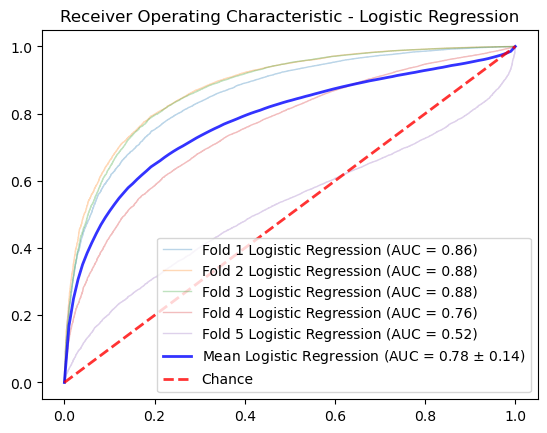

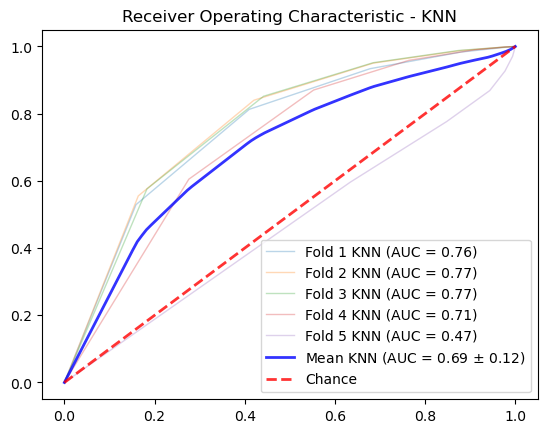

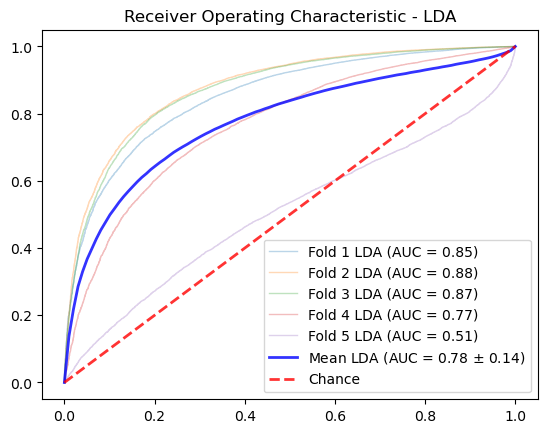

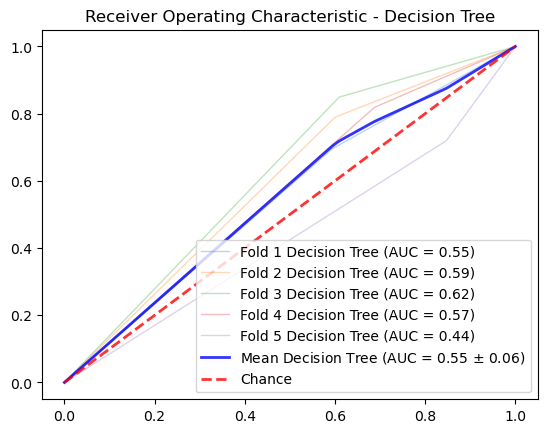

In [37]:
# For Logistic Regression
plot_cv_roc_curve(logistic_classifier, X_train_scaled, y_train, classifier_name='Logistic Regression')

# For KNN
plot_cv_roc_curve(knn_classifier, X_train_scaled, y_train, classifier_name='KNN')

# For LDA
plot_cv_roc_curve(lda_model, X_train_scaled, y_train, classifier_name='LDA')

# For Decision Trees
plot_cv_roc_curve(dt_model, X_train_scaled, y_train, classifier_name='Decision Tree')


### Precision Recall Curve

In [32]:
def plot_cv_precision_recall_curve(classifier, X, y, cv_splits=5, classifier_name='Classifier'):
    """
    Plots Precision-Recall curves for each fold in cross-validation and the mean Precision-Recall curve.
    
    Parameters:
    - classifier: The classifier to use.
    - X: Feature set.
    - y: Target variable.
    - cv_splits: Number of cross-validation splits.
    - classifier_name: Name of the classifier (for legend labeling).
    """
    cv = StratifiedKFold(n_splits=cv_splits)
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    aucs = []
    fig, ax = plt.subplots()
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        probas_ = classifier.predict_proba(X[test])
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1])
        rev_recall = recall[::-1]  # Reverse the recall array
        rev_precision = precision[::-1]  # Reverse the precision array
        precisions.append(np.interp(mean_recall, rev_recall, rev_precision))
        precisions[-1][0] = 1.0
        pr_auc = auc(rev_recall, rev_precision)
        aucs.append(pr_auc)
        ax.plot(recall, precision, lw=1, alpha=0.3, label=f'Fold {i+1} {classifier_name} (AUC = {pr_auc:.2f})')
    
    mean_precision = np.mean(precisions, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    ax.plot(mean_recall, mean_precision, color='b', label=f'Mean {classifier_name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
    ax.set(xlim=[0, 1.05], ylim=[0, 1.05], title=f"Precision-Recall Curve - {classifier_name}")
    ax.legend(loc="lower left")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


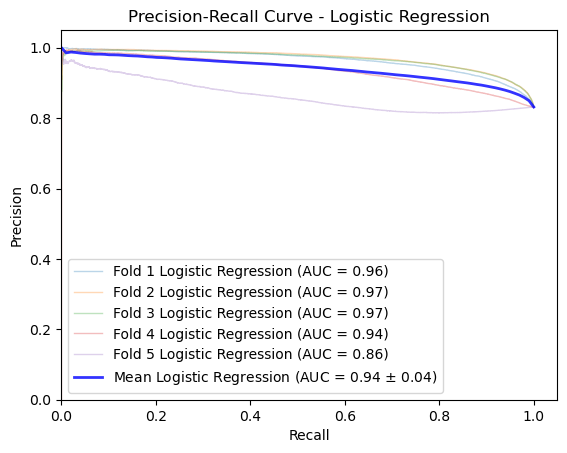

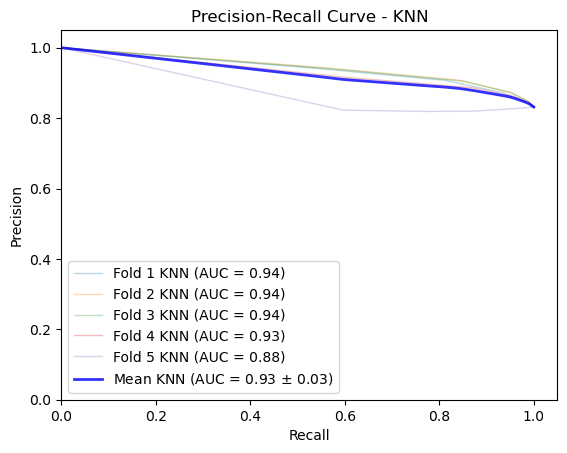

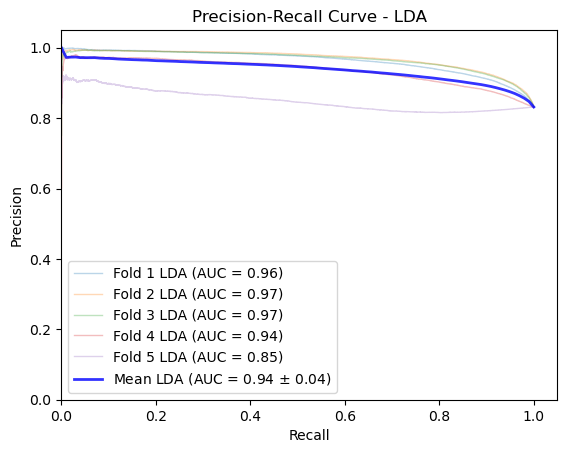

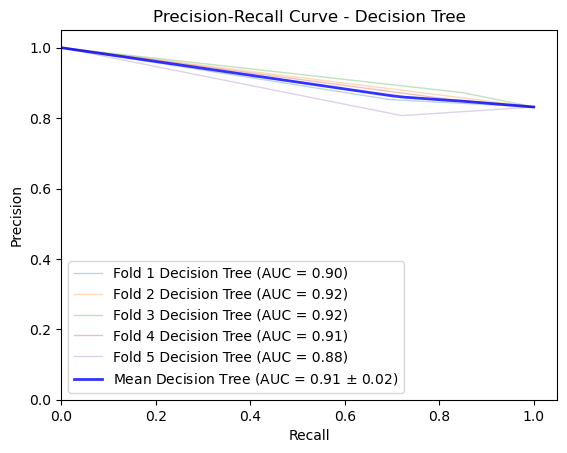

In [33]:
# For Logistic Regression
plot_cv_precision_recall_curve(logistic_classifier, X_train_scaled, y_train, classifier_name='Logistic Regression')

# For KNN
plot_cv_precision_recall_curve(knn_classifier, X_train_scaled, y_train, classifier_name='KNN')

# For LDA
plot_cv_precision_recall_curve(lda_model, X_train_scaled, y_train, classifier_name='LDA')

# For Decision Trees
plot_cv_precision_recall_curve(dt_model, X_train_scaled, y_train, classifier_name='Decision Tree')

## Feature Engineering
### Investigating Features used in the models

- Here is the table summarizing the performance and resource utilization of the models:

| Model                | Precision-Recall AUC | ROC AUC | F1 Score | Training Time (seconds) | Peak Memory (MiB) | Memory Increment (MiB) |
|----------------------|----------------------|---------|----------|-------------------------|-------------------|------------------------|
| LDA                  | 0.94                 | 0.776   | 0.901    | 2.781                   | 1236.81           | 732.88                 |
| Decision Tree        | 0.91                 | 0.552   | 0.810    | 16.527                  | 583.27            | 76.55                  |
| Logistic Regression  | 0.94                 | 0.779   | 0.903    | 1.023                   | 824.35            | 147.03                 |
| KNN                  | 0.93                 | 0.694   | 0.895    | 0.094                   | 820.09            | 142.79                 |

